In [ ]:
# --- Install dependencies (Colab) ---
import sys, subprocess, pkg_resources

def pip_install(args):
    print("Installing:", ' '.join(args))
    return subprocess.check_call([sys.executable, "-m", "pip", "install", *args])

try:
    import torch
except Exception:
    pip_install(["torch", "torchvision", "torchaudio", "--index-url", "https://download.pytorch.org/whl/cpu"])
    import torch

torch_v = torch.__version__.split('+')[0]
print("Torch:", torch.__version__)

# Install PyG wheels compatible with the Torch version
wurl = f"https://data.pyg.org/whl/torch-{torch_v}+cpu.html"
to_install = [
    "torch_geometric",
    "torch_scatter",
    "torch_sparse",
    "torch_cluster",
]
pip_install([*to_install, "-f", wurl])

pip_install(["scikit-learn", "pandas", "matplotlib", "networkx", "numpy"])

/tmp/ipython-input-2924517861.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import sys, subprocess, pkg_resources


Torch: 2.8.0+cu126
Installing: torch_geometric torch_scatter torch_sparse torch_cluster -f https://data.pyg.org/whl/torch-2.8.0+cpu.html
Installing: scikit-learn pandas matplotlib networkx numpy


0

In [ ]:
# --- Imports & seed ---
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
import warnings
warnings.filterwarnings('ignore')

rng = np.random.default_rng(42)
torch.manual_seed(42)
np.random.seed(42)


In [ ]:
import os
CSV_PATH = '/content/creditcard.csv'  # change if needed

if not os.path.exists(CSV_PATH):
    try:
        from google.colab import files
        print("Please upload creditcard.csv (from Kaggle dataset)")
        uploaded = files.upload()
        CSV_PATH = list(uploaded.keys())[0]
    except Exception:
        raise FileNotFoundError("creditcard.csv not found. Upload it or set CSV_PATH correctly.")

df = pd.read_csv(CSV_PATH)
print(df.shape, df.columns[:10])
assert set(['Time','Amount','Class']).issubset(df.columns), "Expected columns Time, Amount, Class to exist."


(284807, 31) Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9'], dtype='object')


In [ ]:
num_fraud = df['Class'].sum()
print(f"Number of fraud samples: {num_fraud}")

num_nonfraud = len(df) - num_fraud
print(f"Number of non-fraud samples: {num_nonfraud}")


Number of fraud samples: 492
Number of non-fraud samples: 284315


In [ ]:
def create_symbolic_features(df: pd.DataFrame) -> pd.DataFrame:
    sym = pd.DataFrame(index=df.index)
    # Amount bins
    sym['Sym_HighAmount'] = (df['Amount'] > df['Amount'].quantile(0.95)).astype(int)
    sym['Sym_VeryHighAmount'] = (df['Amount'] > df['Amount'].quantile(0.99)).astype(int)
    sym['Sym_LowAmount'] = (df['Amount'] < df['Amount'].quantile(0.25)).astype(int)
    sym['Sym_ZeroAmount'] = (df['Amount'] == 0).astype(int)

    # V1..V28 availability varies by dataset; focus on top KL divergence features
    top_features = ['V11', 'V4', 'V18', 'V12', 'V14', 'V17', 'V16']
    for c in top_features:
        if c in df.columns:
            Q1, Q3 = df[c].quantile(0.25), df[c].quantile(0.75)
            IQR = Q3 - Q1
            sym[f'Sym_{c}_Outlier'] = (((df[c] < Q1 - 1.5*IQR) | (df[c] > Q3 + 1.5*IQR))).astype(int)
            sym[f'Sym_{c}_Extreme'] = (((df[c] < df[c].quantile(0.01)) | (df[c] > df[c].quantile(0.99)))).astype(int)  # tighter cutoff
            sym[f'Sym_{c}_Positive'] = (df[c] > 0).astype(int)
            sym[f'Sym_{c}_Negative'] = (df[c] < 0).astype(int)

    # Time-of-day bins from seconds since start (approx hour)
    hour = (df['Time'] % 86400) // 3600
    sym['Sym_EarlyMorning'] = hour.isin([2,3,4,5]).astype(int)
    sym['Sym_LaterMorning'] = hour.isin([6,7,8,9]).astype(int)
    sym['Sym_Night'] = hour.isin([22,23,0,1]).astype(int)

    # Composite indicators
    outlier_cols = [col for col in sym.columns if col.endswith('_Outlier')]
    sym['Sym_OutlierCount'] = sym[outlier_cols].sum(axis=1) if outlier_cols else 0

    extreme_cols = [col for col in sym.columns if col.endswith('_Extreme')]
    sym['Sym_ExtremeCount'] = sym[extreme_cols].sum(axis=1) if extreme_cols else 0

    # Composite feature example
    if 'Sym_V11_Outlier' in sym.columns and 'Sym_HighAmount' in sym.columns:
        sym['Sym_V11_HighAmount_Outlier'] = (sym['Sym_V11_Outlier'] & sym['Sym_HighAmount']).astype(int)
    else:
        sym['Sym_V11_HighAmount_Outlier'] = 0

    # Anomalous pattern composite feature
    sym['Sym_AnomalousPattern'] = (sym[outlier_cols].sum(axis=1) >= 3).astype(int) if outlier_cols else 0

    return sym

symbolic = create_symbolic_features(df)
symbolic_cols = list(symbolic.columns)
print("#symbolic features:", len(symbolic_cols))


#symbolic features: 39


In [ ]:
def extract_rules(symbolic_df: pd.DataFrame, y: pd.Series,
                  min_diff=0.1, top_k_pairs=10):
    rules = {}
    sym_cols = list(symbolic_df.columns)
    fraud = symbolic_df[y==1]
    normal = symbolic_df[y==0]

    for c in sym_cols:
        f_true = fraud[c].mean() if len(fraud) > 0 else 0
        n_true = normal[c].mean() if len(normal) > 0 else 0
        diff = f_true - n_true
        if diff > min_diff:
            sign = 1
            rules[f"IF {c} THEN Fraud"] = {
                'confidence': float(f_true),
                'support': float((fraud[c]==1).mean() if len(fraud)>0 else 0),
                'lift': float(f_true / (n_true + 1e-8)),
                'sign': sign
            }
        elif diff < -min_diff:
            sign = -1
            rules[f"IF {c} THEN Fraud"] = {
                'confidence': float(f_true),
                'support': float((fraud[c]==1).mean() if len(fraud)>0 else 0),
                'lift': float(f_true / (n_true + 1e-8)),
                'sign': sign
            }

    rules = dict(sorted(rules.items(), key=lambda kv: abs(kv[1]['lift']), reverse=True))
    return rules

y = df['Class'].astype(int)
rules = extract_rules(symbolic, y)
print("Top 10 rules:")
for i,(r,info) in enumerate(list(rules.items())[:10]):
    print(f"{i+1:02d}. {r} | conf={info['confidence']:.3f}, lift={info['lift']:.2f}")

# Precompute per-node rule confidence: max confidence among active single-feature rules
sym_mat = symbolic.values.astype(np.float32)
col_index = {c:i for i,c in enumerate(symbolic.columns)}
rule_list = [(r,info) for r,info in rules.items() if r.startswith('IF ')]
node_rule_conf = np.zeros(len(df), dtype=np.float32)
for r,info in rule_list:
    feat = r.split()[1]
    j = col_index.get(feat, None)
    if j is None:
        continue
    active = sym_mat[:, j] > 0.5
    node_rule_conf[active] = np.maximum(node_rule_conf[active], info['confidence'])
node_rule_conf = torch.from_numpy(node_rule_conf)
print("Computed per-node rule confidences.")


Top 10 rules:
01. IF Sym_V11_Outlier THEN Fraud | conf=0.598, lift=349.58
02. IF Sym_AnomalousPattern THEN Fraud | conf=0.839, lift=104.31
03. IF Sym_V14_Extreme THEN Fraud | conf=0.837, lift=45.04
04. IF Sym_V17_Extreme THEN Fraud | conf=0.809, lift=43.40
05. IF Sym_V12_Extreme THEN Fraud | conf=0.740, lift=39.44
06. IF Sym_V11_Extreme THEN Fraud | conf=0.699, lift=37.13
07. IF Sym_ExtremeCount THEN Fraud | conf=4.713, lift=35.67
08. IF Sym_V16_Extreme THEN Fraud | conf=0.665, lift=35.18
09. IF Sym_V17_Outlier THEN Fraud | conf=0.807, lift=32.67
10. IF Sym_V16_Outlier THEN Fraud | conf=0.713, lift=25.89
Computed per-node rule confidences.


In [ ]:
# Use the full dataset
df_full, symbolic_full, y_full = df.copy(), symbolic.copy(), df['Class'].astype(int).reset_index(drop=True)

# Features as float32
X_sym = symbolic_full.values.astype(np.float32)
print("Full dataset:", X_sym.shape, "fraud rate:", y_full.mean())

Full dataset: (284807, 39) fraud rate: 0.001727485630620034


In [ ]:

# kNN with cosine distance
k = 10
nbrs = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='brute').fit(X_sym)
_, idx = nbrs.kneighbors(X_sym)
src = np.repeat(np.arange(X_sym.shape[0]), k).astype(np.int64)
dst = idx.reshape(-1).astype(np.int64)
edge_index = np.vstack([src, dst])


In [ ]:


# Torch tensors
x = torch.from_numpy(X_sym)
edge_index = torch.from_numpy(edge_index)
y_t = torch.from_numpy(y_full.values if hasattr(y_full, 'values') else np.array(y_full)).long()

# Train-test masks (stratified)
train_ids, test_ids = train_test_split(
    np.arange(len(y_t)),
    test_size=0.2,
    stratify=y_t.numpy(),
    random_state=42
)
train_mask = torch.zeros(len(y_t), dtype=torch.bool)
train_mask[train_ids] = True
test_mask = torch.zeros(len(y_t), dtype=torch.bool)
test_mask[test_ids] = True

# PyG Data object
data = Data(x=x, edge_index=edge_index, y=y_t,
            train_mask=train_mask, test_mask=test_mask)
print(data)


Data(x=[284807, 39], edge_index=[2, 2848070], y=[284807], train_mask=[284807], test_mask=[284807])


In [ ]:
class SymbolicGNN(nn.Module):
    def __init__(self, num_features, rule_embedding_dim=16, hidden_dim=64, heads=4, backbone="GAT"):
        super().__init__()
        self.symbolic_encoder = nn.Sequential(
            nn.Linear(num_features, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.rule_embeddings = nn.Embedding(256, rule_embedding_dim)  # 0 is PAD

        if backbone == "GAT":
            self.conv1 = GATConv(hidden_dim // 2 + rule_embedding_dim, hidden_dim, heads=heads, dropout=0.3)
            self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, dropout=0.3, concat=False)
        elif backbone == "GCN":
            self.conv1 = GCNConv(hidden_dim // 2 + rule_embedding_dim, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, hidden_dim)
        elif backbone == "GraphSAGE":
            self.conv1 = SAGEConv(hidden_dim // 2 + rule_embedding_dim, hidden_dim)
            self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        else:
            raise ValueError(f"Unknown backbone {backbone}")

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)
        )
    def forward(self, data, rule_ids_per_node=None, rule_signs_per_node=None):
        x, edge_index = data.x, data.edge_index
        x = self.symbolic_encoder(x)

        if rule_ids_per_node is None:
            rule_emb = torch.zeros(x.size(0), self.rule_embeddings.embedding_dim, device=x.device)
        else:
            embeddings = self.rule_embeddings(rule_ids_per_node)  # shape: (N, topK, emb_dim)
            if rule_signs_per_node is not None:
                sign_expanded = rule_signs_per_node.unsqueeze(-1)  # (N, topK, 1)
                embeddings = embeddings * sign_expanded  # apply sign to embeddings
            rule_emb = embeddings.mean(dim=1)  # average over topK rules

        x = torch.cat([x, rule_emb], dim=1)
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        return self.classifier(x)


def make_rule_ids_and_signs(symbolic_df, rules, topK=3):
    ids = {}
    rid = 1
    col_index = {c: i for i, c in enumerate(symbolic_df.columns)}

    # Map feature to id and store sign (+1 fraud, -1 normal)
    signs_map = {}

    for r, info in rules.items():
        feat = r.split()[1]
        if feat not in ids:
            ids[feat] = rid
            signs_map[feat] = info['sign']
            rid += 1

    N = len(symbolic_df)
    R = torch.zeros((N, topK), dtype=torch.long)
    S = torch.zeros((N, topK), dtype=torch.float32)  # signs: +1 or -1

    for i in range(N):
        active = []
        for r, info in rules.items():
            feat = r.split()[1]
            j = col_index.get(feat, None)
            if j is not None and symbolic_df.iat[i, j] > 0.5:
                active.append((ids[feat], info['confidence'], signs_map[feat]))
        active.sort(key=lambda t: -t[1])
        for k in range(min(topK, len(active))):
            R[i, k] = active[k][0]
            S[i, k] = active[k][2]

    return R, S

rule_ids_per_node, rule_signs_per_node = make_rule_ids_and_signs(symbolic_full, rules, topK=3)
print("rule_ids_per_node shape:", rule_ids_per_node.shape,"rule_ids_sign shape:",rule_signs_per_node)


rule_ids_per_node shape: torch.Size([284807, 3]) rule_ids_sign shape: tensor([[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [ 1.,  1., -1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]])


## 6) Train

In [ ]:
backbone_choice = "GCN" #please note to change backbone choice change 'GCN' to other backbones mentiones

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SymbolicGNN(num_features=x.shape[1], backbone=backbone_choice).to(device)
data = Data(x=x, edge_index=edge_index, y=y_t, train_mask=train_mask, test_mask=test_mask).to(device)
rule_ids_per_node = rule_ids_per_node.to(device)
rule_signs_per_node = rule_signs_per_node.to(device)
node_rule_conf = node_rule_conf.to(device)


# Class weights
counts = torch.bincount(data.y[data.train_mask])
weights = (1.0 / counts.float())
weights = weights / weights.sum() * 2
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

def train_epoch(alpha=0.1):
    model.train()
    optimizer.zero_grad()
    out = model(data, rule_ids_per_node)
    ce = criterion(out[data.train_mask], data.y[data.train_mask])
    p = F.softmax(out, dim=1)[:, 1]
    rule_loss = torch.mean(torch.abs(p[data.train_mask] - node_rule_conf[data.train_mask]))
    loss = ce + alpha * rule_loss
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    # Safely convert to float even if rule_loss is already float
    ce_val = ce.item() if hasattr(ce, 'item') else ce
    loss_val = loss.item() if hasattr(loss, 'item') else loss
    rule_loss_val = rule_loss.item() if hasattr(rule_loss, 'item') else rule_loss

    return loss_val, ce_val, rule_loss_val

def eval_model():
    model.eval()
    with torch.no_grad():
        out = model(data, rule_ids_per_node)
        preds = out.argmax(1)
        test_acc = (preds[data.test_mask] == data.y[data.test_mask]).float().mean().item()
        probs = F.softmax(out, dim=1)[:, 1]
        y_true = data.y[data.test_mask].cpu().numpy()
        y_prob = probs[data.test_mask].cpu().numpy()
        pr_auc = average_precision_score(y_true, y_prob)
    return test_acc, pr_auc, y_true, y_prob


EPOCHS = 100
for e in range(1, EPOCHS + 1):
    loss, ce, rl = train_epoch(alpha=0.1)
    if e == 1 or e % 10 == 0:
        acc, pr, _, _ = eval_model()
        print(f"Epoch {e:03d} | loss={loss:.4f} (ce={ce:.4f}, rl={rl:.4f}) | acc={acc:.4f} | PR-AUC={pr:.4f}")


Epoch 001 | loss=0.8537 (ce=0.7331, rl=1.2060) | acc=0.3655 | PR-AUC=0.0022
Epoch 010 | loss=0.6398 (ce=0.5161, rl=1.2371) | acc=0.8195 | PR-AUC=0.0467
Epoch 020 | loss=0.5179 (ce=0.3857, rl=1.3220) | acc=0.8627 | PR-AUC=0.1017
Epoch 030 | loss=0.4319 (ce=0.2832, rl=1.4872) | acc=0.9482 | PR-AUC=0.2676
Epoch 040 | loss=0.4054 (ce=0.2472, rl=1.5815) | acc=0.9634 | PR-AUC=0.3422
Epoch 050 | loss=0.3795 (ce=0.2229, rl=1.5666) | acc=0.9618 | PR-AUC=0.3501
Epoch 060 | loss=0.3629 (ce=0.2055, rl=1.5742) | acc=0.9740 | PR-AUC=0.3954
Epoch 070 | loss=0.3523 (ce=0.1931, rl=1.5915) | acc=0.9737 | PR-AUC=0.4022
Epoch 080 | loss=0.3411 (ce=0.1814, rl=1.5963) | acc=0.9766 | PR-AUC=0.4513
Epoch 090 | loss=0.3404 (ce=0.1805, rl=1.5996) | acc=0.9768 | PR-AUC=0.4901
Epoch 100 | loss=0.3291 (ce=0.1680, rl=1.6115) | acc=0.9786 | PR-AUC=0.5392


## 7) Evaluation & PR curve

In [ ]:
# after training:
from sklearn.metrics import precision_recall_curve

# make a validation split from your train set
val_ids, train_core = train_test_split(np.where(data.train_mask.cpu())[0],
                                       test_size=0.8, stratify=data.y[data.train_mask].cpu(),
                                       random_state=42)
val_mask = torch.zeros_like(data.train_mask); val_mask[val_ids]=True
core_mask = torch.zeros_like(data.train_mask); core_mask[train_core]=True
data.train_mask = core_mask  # keep training on core_mask if you want to retrain; or just use val_mask for thresholding

model.eval()
with torch.no_grad():
    out = model(data, rule_ids_per_node)
    p = F.softmax(out, dim=1)[:,1].cpu().numpy()

y_val = data.y[val_mask].cpu().numpy()
p_val = p[val_mask.cpu().numpy()]

prec, rec, thr = precision_recall_curve(y_val, p_val)
target_precision = 0.25  # tweak to taste
idx = (prec >= target_precision).nonzero()[0]
best_t = thr[idx[0]-1] if len(idx)>0 and idx[0]>0 else 0.5

# Evaluate on test with this threshold
y_test = data.y[data.test_mask].cpu().numpy()
p_test = p[data.test_mask.cpu().numpy()]
y_pred = (p_test >= best_t).astype(int)
print("Best threshold:", round(float(best_t),4))
print(classification_report(y_test, y_pred, digits=4))

Best threshold: 0.9077
              precision    recall  f1-score   support

           0     0.9998    0.9956    0.9977     56864
           1     0.2530    0.8571    0.3907        98

    accuracy                         0.9954     56962
   macro avg     0.6264    0.9264    0.6942     56962
weighted avg     0.9985    0.9954    0.9966     56962



Final Test Accuracy: 0.9786
Final PR-AUC: 0.5392
              precision    recall  f1-score   support

           0     0.9998    0.9787    0.9892     56864
           1     0.0678    0.8980    0.1262        98

    accuracy                         0.9786     56962
   macro avg     0.5338    0.9383    0.5577     56962
weighted avg     0.9982    0.9786    0.9877     56962



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

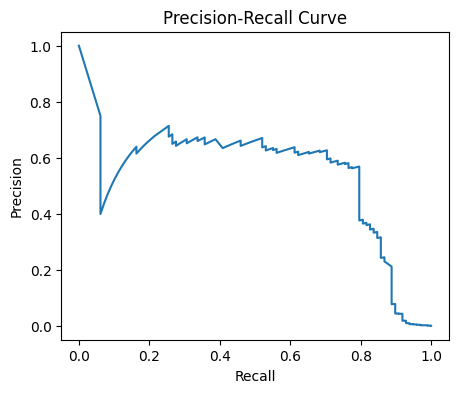

In [ ]:
from google.colab import files
acc, prauc, y_true, y_prob = eval_model()
print(f"Final Test Accuracy: {acc:.4f}")
print(f"Final PR-AUC: {prauc:.4f}")

from sklearn.metrics import classification_report
y_pred = (y_prob >= 0.5).astype(int)
print(classification_report(y_true, y_pred, digits=4))

prec, rec, thr = precision_recall_curve(y_true, y_prob)
plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
# Save the figure (you already did this)
plt.savefig(f"Credit Card Precision-Recall Curve{backbone_choice.lower()}.png", dpi=300, bbox_inches='tight')

# Trigger download
files.download(f"Credit Card Precision-Recall Curve{backbone_choice.lower()}.png")

# Trigger download
plt.show()

Final ROC-AUC: 0.9689


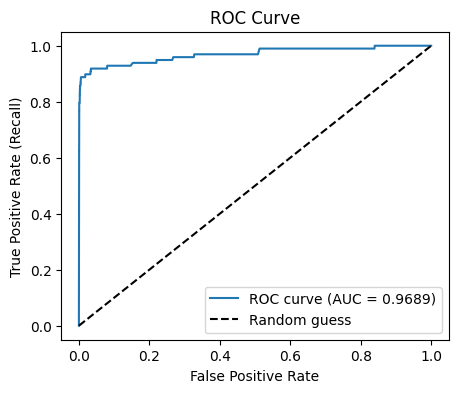

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

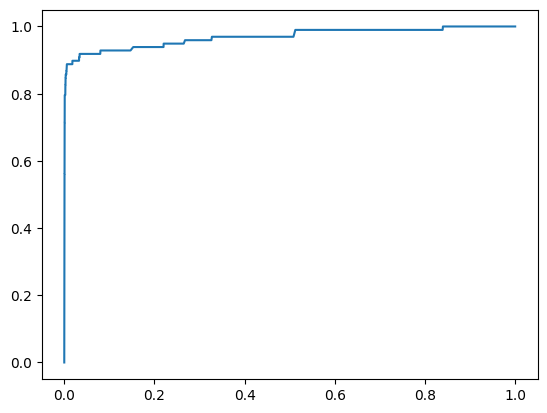

In [ ]:
from google.colab import files
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
print(f"Final ROC-AUC: {roc_auc:.4f}")


plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig(f"credit card ROC Curve{backbone_choice.lower()}.png", dpi=300, bbox_inches='tight')
plt.show()
files.download(f"credit card ROC Curve{backbone_choice.lower()}.png")
print(plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
)

In [ ]:
idx_to_feat = np.array(symbolic_full.columns)
def explain_nodes(indices, top_rules=5):
    model.eval()
    with torch.no_grad():
        out = model(data, rule_ids_per_node)
        probs = F.softmax(out, dim=1)[:,1].detach().cpu().numpy()
    for i in indices:
        feat_vals = data.x[i].cpu().numpy()
        actives = idx_to_feat[feat_vals > 0.5]
        # top K rule names by confidence that are active
        active_rules = []
        for r,info in rules.items():
            feat = r.split()[1]
            if feat in actives:
                active_rules.append((r, info['confidence']))
        active_rules.sort(key=lambda t:-t[1])
        print(f"\nNode {i} | True={int(data.y[i].item())} | P(fraud)={probs[i]:.3f}")
        print("Active symbolic features (first 10):", list(actives[:10]))
        print("Rules triggered:")
        for r,c in active_rules[:top_rules]:
            print(f"  - {r} (conf={c:.3f})")

sample = np.random.choice(np.where(data.test_mask.cpu().numpy())[0], size=3, replace=False)
explain_nodes(sample)


Node 105136 | True=0 | P(fraud)=0.050
Active symbolic features (first 10): ['Sym_V11_Negative', 'Sym_V4_Negative', 'Sym_V18_Positive', 'Sym_V12_Negative', 'Sym_V14_Negative', 'Sym_V17_Positive', 'Sym_V16_Positive']
Rules triggered:
  - IF Sym_V14_Negative THEN Fraud (conf=0.951)
  - IF Sym_V12_Negative THEN Fraud (conf=0.949)
  - IF Sym_V18_Positive THEN Fraud (conf=0.262)
  - IF Sym_V17_Positive THEN Fraud (conf=0.197)
  - IF Sym_V16_Positive THEN Fraud (conf=0.163)

Node 117656 | True=0 | P(fraud)=0.008
Active symbolic features (first 10): ['Sym_LowAmount', 'Sym_V11_Negative', 'Sym_V4_Negative', 'Sym_V18_Negative', 'Sym_V12_Positive', 'Sym_V14_Negative', 'Sym_V17_Negative', 'Sym_V16_Positive']
Rules triggered:
  - IF Sym_V14_Negative THEN Fraud (conf=0.951)
  - IF Sym_V17_Negative THEN Fraud (conf=0.803)
  - IF Sym_V18_Negative THEN Fraud (conf=0.738)
  - IF Sym_LowAmount THEN Fraud (conf=0.455)
  - IF Sym_V16_Positive THEN Fraud (conf=0.163)

Node 2436 | True=0 | P(fraud)=0.028
Act

In [ ]:
torch.save(model.state_dict(), 'symbolic_gnn_model.pt')
pd.DataFrame([{'rule':r, **info} for r,info in rules.items()]).to_csv('gcn_extracted_rules.csv', index=False)
print("Saved: gcn_symbolic_gnn_model.pt, extracted_rules.csv")

Saved: gcn_symbolic_gnn_model.pt, extracted_rules.csv


Confusion Matrix:
 [[55321  1543]
 [   10    88]]


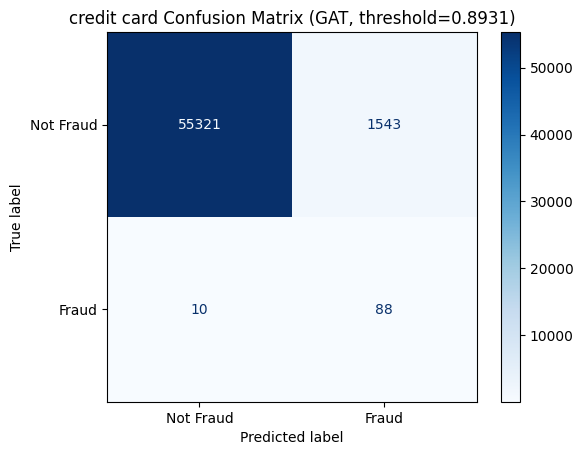

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"credit card Confusion Matrix ({backbone_choice}, threshold={best_t:.4f})")
print("Confusion Matrix:\n", cm)


# Save figure once before showing
filename = f"credit card confusion_matrix_{backbone_choice.lower()}.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

# Trigger download after showing
files.download(filename)



In [ ]:
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9998    0.9223    0.9595     56864
           1     0.0200    0.9184    0.0391        98

    accuracy                         0.9223     56962
   macro avg     0.5099    0.9203    0.4993     56962
weighted avg     0.9982    0.9223    0.9579     56962



In [ ]:
num_fraud = (y_test == 1).sum()
print(f"Number of fraud samples in test set: {num_fraud}")


Number of fraud samples in test set: 98
